In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, average_precision_score,
    confusion_matrix, classification_report, PrecisionRecallDisplay, roc_curve, precision_recall_curve # <-- Убедитесь, что эта строка здесь
)
from sklearn.preprocessing import StandardScaler 
from imblearn.over_sampling import SMOTE 

from xgboost import XGBClassifier # Для XGBoost
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import warnings
from sklearn.neighbors import KNeighborsClassifier

In [2]:
warnings.filterwarnings('ignore')
df = pd.read_csv('df_volatility.csv')
df.head()

,Date,Close,High,Low,Open,Volume,Log_Return,Rolling_Volatility,Future_Vol,Target_Volatility_Spike,...,BB_Percent,KC_high,KC_low,KC_mid,KC_Percent,ATR,DayOfWeek_sin,DayOfMonth_sin,DayOfWeek_cos,DayOfMonth_cos
0,2015-10-04,238.259003,238.968002,237.940002,238.531006,12999000,-0.001975,0.215965,0.261876,0,...,0.899884,238.322569,229.108565,233.715567,1.044218,4.857551,-0.781831,0.724793,0.623490,0.688967
1,2015-10-05,240.382996,240.382996,237.035004,238.147003,23335900,0.008875,0.196121,0.257367,0,...,0.826996,238.552053,229.683148,234.117601,0.966958,4.584011,0.000000,0.848644,1.000000,0.528964
2,2015-10-06,246.063004,246.934998,240.136002,240.363998,27535100,0.023354,0.198389,0.253517,0,...,0.918677,237.226335,230.958632,234.092484,1.503639,4.495724,0.781831,0.937752,0.623490,0.347305
3,2015-10-07,242.968994,246.681000,242.585007,246.169998,22999200,-0.012654,0.216683,0.165395,0,...,1.136460,238.132735,231.566432,234.849584,2.207722,4.660244,0.974928,0.988468,-0.222521,0.151428
4,2015-10-08,242.304001,244.251007,242.179001,243.074997,18515300,-0.002741,0.223977,0.126219,0,...,0.905709,238.989818,232.149817,235.569817,1.581751,4.619940,0.433884,0.998717,-0.900969,-0.050649


In [3]:
df.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Log_Return',
       'Rolling_Volatility', 'Future_Vol', 'Target_Volatility_Spike',
       'Log_Return_lag_1', 'Log_Return_lag_2', 'Log_Return_lag_3',
       'Log_Return_lag_5', 'Log_Return_lag_10', 'Log_Return_lag_14',
       'Daily_Range_Ratio', 'Open_Prev_Close_Gap_Ratio',
       'Close_Position_in_Range', 'Close_Open_Ratio', 'Volume_lag_1',
       'Volume_lag_2', 'Volume_lag_3', 'Volume_lag_5', 'Volume_lag_10',
       'Volume_MA', 'Volume_to_MA_Ratio', 'Volume_Daily_Change_Ratio',
       'Rolling_Volatility_lag_1', 'Rolling_Volatility_lag_2',
       'Rolling_Volatility_lag_3', 'Rolling_Volatility_lag_5',
       'Rolling_Volatility_lag_10', 'Rolling_Volatility_Daily_Change_Ratio',
       'Short_Term_Volatility', 'Long_Term_Volatility', 'Vol_Ratio_Short_Long',
       'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_Upper', 'BB_Lower',
       'BB_Width', 'BB_Percent', 'KC_high', 'KC_low', 'KC_mid', 'KC_Percent',
       'ATR', 'Day

In [4]:
feature_columns = [col for col in df.columns if col not in ['Open', 'High', 'Low', 'Close', 'Volume','Date',
                                                            'Log_Return', 'Rolling_Volatility', 'Volume_MA',
                                                            'Short_Term_Volatility', 'Long_Term_Volatility', 'Future_Vol',
                                                            'Target_Volatility_Spike']] # Исключаем целевую

In [5]:
X = df[feature_columns]
y = df['Target_Volatility_Spike']

In [6]:
y.value_counts()

Target_Volatility_Spike
0    3313
1     373
Name: count, dtype: int64

In [7]:
X.head()

,Log_Return_lag_1,Log_Return_lag_2,Log_Return_lag_3,Log_Return_lag_5,Log_Return_lag_10,Log_Return_lag_14,Daily_Range_Ratio,Open_Prev_Close_Gap_Ratio,Close_Position_in_Range,Close_Open_Ratio,...,BB_Percent,KC_high,KC_low,KC_mid,KC_Percent,ATR,DayOfWeek_sin,DayOfMonth_sin,DayOfWeek_cos,DayOfMonth_cos
0,0.006038,-0.001078,0.006288,-0.010319,0.018270,-0.001215,0.009932,-0.006401,0.753266,1.006442,...,0.899884,238.322569,229.108565,233.715567,1.044218,4.857551,-0.781831,0.724793,0.623490,0.688967
1,-0.001975,0.006038,-0.001078,-0.002653,0.002619,-0.018011,0.004315,0.001142,0.310312,0.998860,...,0.826996,238.552053,229.683148,234.117601,0.966958,4.584011,0.000000,0.848644,1.000000,0.528964
2,0.008875,-0.001975,0.006038,0.006288,-0.003425,0.015438,0.013928,-0.009302,1.000000,1.009389,...,0.918677,237.226335,230.958632,234.092484,1.503639,4.495724,0.781831,0.937752,0.623490,0.347305
3,0.023354,0.008875,-0.001975,-0.001078,-0.006778,-0.001454,0.027631,-0.023161,0.871747,1.023710,...,1.136460,238.132735,231.566432,234.849584,2.207722,4.660244,0.974928,0.988468,-0.222521,0.151428
4,-0.012654,0.023354,0.008875,0.006038,0.027063,0.018270,0.016858,0.013175,0.093747,0.986997,...,0.905709,238.989818,232.149817,235.569817,1.581751,4.619940,0.433884,0.998717,-0.900969,-0.050649


In [8]:
from sklearn.metrics import roc_curve, auc
from sklearn.compose import ColumnTransformer

In [9]:
corr = df[feature_columns + ['Target_Volatility_Spike']].corr()['Target_Volatility_Spike'].sort_values(ascending=False)
print(corr.head(10))  # Топ корреляций
print(corr.tail(10))  # Низкие

Target_Volatility_Spike      1.000000
Daily_Range_Ratio            0.335556
BB_Width                     0.333953
Rolling_Volatility_lag_1     0.310209
Rolling_Volatility_lag_2     0.291034
Rolling_Volatility_lag_3     0.271201
Rolling_Volatility_lag_5     0.233252
Rolling_Volatility_lag_10    0.188506
Vol_Ratio_Short_Long         0.186911
Volume_to_MA_Ratio           0.092866
Name: Target_Volatility_Spike, dtype: float64
Log_Return_lag_2   -0.063571
Log_Return_lag_1   -0.066143
KC_Percent         -0.069004
MACD_Diff          -0.076239
BB_Percent         -0.097719
BB_Upper           -0.103380
KC_high            -0.109039
KC_mid             -0.113147
KC_low             -0.117509
BB_Lower           -0.123544
Name: Target_Volatility_Spike, dtype: float64


In [10]:
def model_train_func(model_name, X, y, numeric_features, cyclic_features):
    # Списки для общей ROC-кривой и PR-кривой для текущей модели (храним как списки фолдов)
    model_all_y_test_folds = []
    model_all_y_proba_folds = []
    fold_metrics = []
    
    for fold, (train_index, test_index) in enumerate(TimeSeriesSplit(n_splits=3).split(X)):
        
        print(f"\nFold {fold+1}/{3} для {model_name}")

        # Создаем preprocessor
        preprocessor = ColumnTransformer([
            ('scale', StandardScaler(), numeric_features),
            ('cyclic', 'passthrough', cyclic_features)   ])

        # Создаем pipeline
        steps = [
        ('preprocessor', preprocessor),
         ('smote', SMOTE(random_state=42, sampling_strategy='auto')), 
        ('classifier', model_instance)
        ]
        pipeline = Pipeline(steps)
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        pipeline.fit(X_train, y_train)

        #  Прогнозирование
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:, 1]

        # Оценка метрик
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        pr_auc = average_precision_score(y_test, y_proba)

        if len(np.unique(y_test)) < 2:
            roc_auc = np.nan
            print("Только один класс в тесте → ROC AUC = NaN")
        else:
            roc_auc = roc_auc_score(y_test, y_proba)

        print(f"Результаты для Fold {fold+1} ({model_name}):")
        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f} ")

        fold_metrics.append({'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc, 'PR-AUC': pr_auc})
        
        model_all_y_test_folds.append(y_test.tolist()) # Сохраняем y_test для этого фолда
        model_all_y_proba_folds.append(y_proba.tolist()) # Сохраняем y_proba для этого фолда

    all_y_true = np.concatenate(model_all_y_test_folds)
    all_y_proba = np.concatenate(model_all_y_proba_folds)
    if len(np.unique(all_y_true)) > 1:
        total_roc = roc_auc_score(all_y_true, all_y_proba)
        print(f"{model_name} — Общий ROC AUC по всем фолдам: {total_roc:.4f}")
    else:
        print("Нет класса 1 во всех фолдах — ROC NaN")
    
    all_models_results = {
        'fold_metrics': fold_metrics,
        'all_y_test_folds': model_all_y_test_folds, # Список списков для каждого фолда
        'all_y_proba_folds': model_all_y_proba_folds 
        #'total_roc': total_roc
        }
    return all_models_results

In [11]:
models = {
    'LogisticRegression': LogisticRegression(
        random_state=42, 
        C=0.1, 
        penalty='l2', 
        solver='lbfgs', 
        max_iter=1000,
        class_weight='balanced'
    ),
    'XGBClassifier': XGBClassifier(
        random_state=42, max_depth=4, eval_metric='logloss', use_label_encoder=False  #  Для XGB аналог class_weight, динамично по train
    )
}

In [12]:
cyclic_features = ['DayOfWeek_sin', 'DayOfMonth_sin', 'DayOfWeek_cos', 'DayOfMonth_cos']
numeric_features = [col for col in feature_columns if col not in cyclic_features]

#Цикл по каждой модели
for model_name, model_instance in models.items():
    fold_metrics = []
    print(f"\nОбучение и оценка модели: {model_name}")
    model_train_func(model_name, X, y, numeric_features, cyclic_features)


Обучение и оценка модели: LogisticRegression

Fold 1/3 для LogisticRegression
Результаты для Fold 1 (LogisticRegression):
Accuracy: 0.4528, Precision: 0.1268, Recall: 0.7609, F1-Score: 0.2174, ROC AUC: 0.6510, PR-AUC: 0.3142 

Fold 2/3 для LogisticRegression
Результаты для Fold 2 (LogisticRegression):
Accuracy: 0.3963, Precision: 0.1386, Recall: 0.9072, F1-Score: 0.2404, ROC AUC: 0.7690, PR-AUC: 0.3130 

Fold 3/3 для LogisticRegression
Результаты для Fold 3 (LogisticRegression):
Accuracy: 0.9338, Precision: 0.0755, Recall: 0.2500, F1-Score: 0.1159, ROC AUC: 0.8445, PR-AUC: 0.1435 
LogisticRegression — Общий ROC AUC по всем фолдам: 0.7747

Обучение и оценка модели: XGBClassifier

Fold 1/3 для XGBClassifier
Результаты для Fold 1 (XGBClassifier):
Accuracy: 0.5863, Precision: 0.1304, Recall: 0.5543, F1-Score: 0.2112, ROC AUC: 0.6009, PR-AUC: 0.1666 

Fold 2/3 для XGBClassifier
Результаты для Fold 2 (XGBClassifier):
Accuracy: 0.5244, Precision: 0.1527, Recall: 0.7732, F1-Score: 0.2551, ROC

 Видно как рухнули метрики у обоих моделей на 3 фолде по сравнению с первыми двумя. Это говорит о том, что характер всплесков волатильности изменился, и паттерны, выученные на предыдущих фолдах, перестали работать. а у XGB в 3 фолде вообще не смог предсказать ни одного реального всплеска, возможно модель поместила порог слишком высоко и ни один прогноз недостиг его

А ещё LogisticRegression в данной задаче лучше обобщает данные( в этом явно помогает регуляризация) т.к показывает лучшие результаты по сравнению с бустом. xgb переобучается и возможно подстраивается где то под выбросы

In [15]:

# Создаем preprocessor
preprocessor = ColumnTransformer([
('scale', StandardScaler(), numeric_features),
('cyclic', 'passthrough', cyclic_features)   ])

X = df[feature_columns]
y = df['Target_Volatility_Spike']
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Pipeline как в функции для 2ух моделей
steps_lr = [('preprocessor', preprocessor), ('classifier', LogisticRegression(class_weight='balanced', penalty='l2',  C=0.1, random_state=42))]
steps_xgb = [('preprocessor', preprocessor), ('classifier', XGBClassifier(random_state=42, objective='binary:logistic',colsample_bytree=0.4, max_depth=4, eval_metric='aucpr',learning_rate=0.05, n_estimators=200))]

pipeline_lr = Pipeline(steps_lr)
pipeline_xgb = Pipeline(steps_xgb)

pipeline_lr.fit(X_train, y_train)
pipeline_xgb.fit(X_train, y_train)

y_pred_lr = pipeline_lr.predict(X_test)
y_pred_xgb = pipeline_xgb.predict(X_test)

y_proba_lr = pipeline_lr.predict_proba(X_test)[:, 1]
y_proba_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]

roc_lr = roc_auc_score(y_test, y_proba_lr) if len(np.unique(y_test)) > 1 else np.nan
roc_xgb = roc_auc_score(y_test, y_proba_xgb) if len(np.unique(y_test)) > 1 else np.nan

pr_lr = average_precision_score(y_test, y_proba_lr)
pr_xgb = average_precision_score(y_test, y_proba_xgb)


print(f"Hold-out ROC_LR: {roc_lr:.4f}, PR_SCORE_LR: {pr_lr:.4f}")
print(f"Hold-out ROC_XGB: {roc_xgb:.4f}, PR_SCORE_XGB: {pr_xgb:.4f}")

Hold-out ROC_LR: 0.8745, PR_SCORE_LR: 0.1814
Hold-out ROC_XGB: 0.7608, PR_SCORE_XGB: 0.1444


 для лог регрессии roc_auc_score показал сильные улучшения после того как я расширил начало выборки с 2020года до 2015г. PR_SCORE увеличился с 0.1 до 0.17, что всё равно не много, но нужно учитывать характер задачи.

Но основной вклад в улучшения метрик внесло мое пристальное внимание к feature engenering. Изначально было много утечек и модель видила будущее - выдававла всегда ROC AUC: 0.99

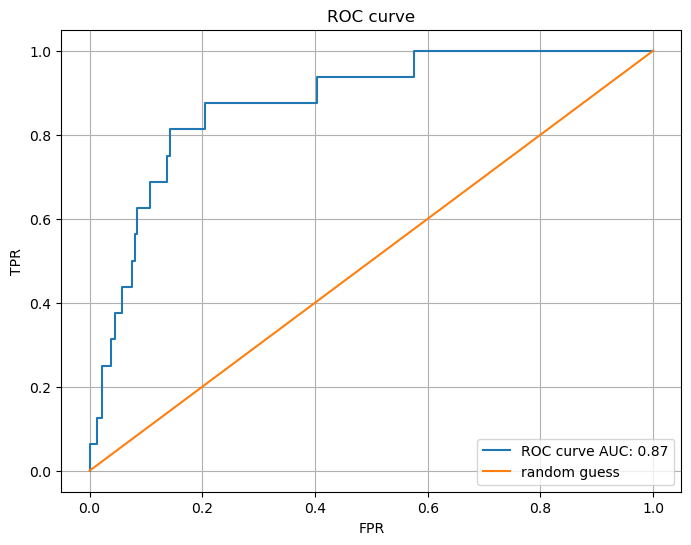

In [18]:
fpr, tpr, tresholds = roc_curve(y_test, y_proba_lr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve AUC: {roc_lr:.2f}')
plt.plot([0, 1], [ 0, 1], label='random guess')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

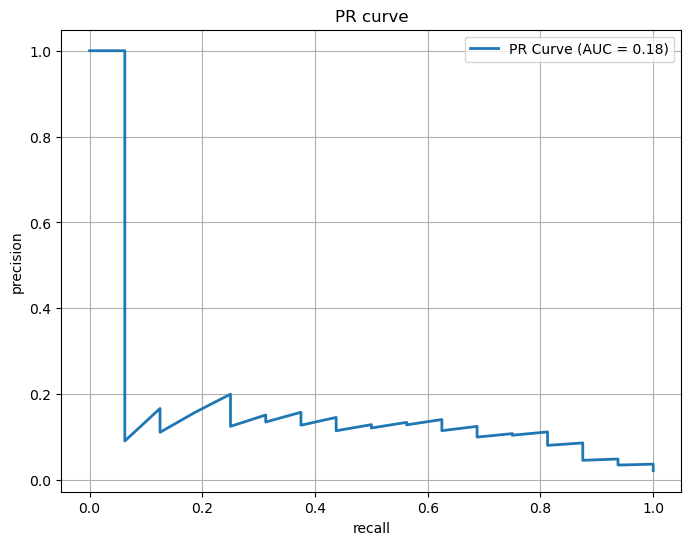

In [19]:
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_proba_lr)
pr_auc = auc(recall_vals, precision_vals)

plt.figure(figsize=(8,6))
plt.plot(recall_vals, precision_vals, label=f'PR Curve (AUC = {pr_lr:.2f})', linewidth=2)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('PR curve')
plt.legend(loc='best')
plt.grid()

## при помощи DBSCAN хочу детектирровать кластеры аномалий

In [21]:
cols_to_drop_db = [
    # 1. Утечка данных (Target Leakage)
    'Future_Vol', 'Target_Volatility_Spike', 'Date',
    
    # 2. Сырые цены и объемы 
    'Close', 'High', 'Low', 'Open', 
    'Volume', 'Volume_MA', 
    'BB_Upper', 'BB_Lower', 
    'KC_high', 'KC_low', 'KC_mid',

    # циклические признаки
    'DayOfWeek_sin', 'DayOfMonth_sin',
    'DayOfWeek_cos', 'DayOfMonth_cos',
    
    # Абсолютная волатильность 
    'ATR',  
    'MACD', 'MACD_Signal' # Оставляю MACD_Diff
]

In [22]:
date_column_name = 'Date'
if date_column_name in df.columns:
    df[date_column_name] = pd.to_datetime(df[date_column_name])
    df = df.set_index(date_column_name)
else:
    print(" ОШИБКА: Колонка с датами не найдена. Проверь название колонки.")

In [23]:
X_db = df.drop(columns=cols_to_drop_db, errors='ignore')
y_db = df['Target_Volatility_Spike']
print(f"Осталось признаков: {X_db.shape[1]}")

Осталось признаков: 33


In [24]:
def dbscan_anomaly_detector(X_db, y_db, train_size):
    
    X_train, X_test = X_db.iloc[:train_size], X_db.iloc[train_size:]
    y_train, y_test = y_db.iloc[:train_size], y_db.iloc[train_size:]
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)
    
    
    pca = PCA(n_components=3)
    X_reduced = pca.fit_transform(X_scaled)
    
    X_test_scaled = scaler.transform(X_test)
    X_test_reduced = pca.transform(X_test_scaled)
    
    # Обучаем DBSCAN только на TRAIN
    # eps и min_samples подбираю вручную
    db = DBSCAN(eps=0.5, min_samples=5) 
    db.fit(X_reduced) # X_reduced получен из X_train
    
    # Получаем метки: -1 это выброс, 0,1,2это кластеры
    labels_train = db.labels_
    
    # 2. Создаем "Обертку" для предсказаний через KNN
    # учим KNN запоминать: "Если точка здесь, то DBSCAN считает её выбросом"
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_reduced, labels_train)
    
    # 3. Предсказываем на TEST честным способом 
    # KNN найдет ближайших соседей из прошлого (Train) и присвоит их метку
    test_labels_pred = knn.predict(X_test_reduced) 
    train_labels_pred = labels_train # Для трейна берем родные метки
    
    y_pred_db_train = (train_labels_pred == -1).astype(int)
    y_pred_db_test = (test_labels_pred == -1).astype(int)

    print(f"DBSCAN (через KNN) нашел аномалий в Train: {y_pred_db_train.sum()}")
    print(f"DBSCAN (через KNN) нашел аномалий в Test: {y_pred_db_test.sum()}")

    return  (y_pred_db_train, y_pred_db_test, X_train.index, X_test.index)
    
train_size = int(len(X_db) * 0.8)
y_pred_db_train, y_pred_db_test, train_idx, test_idx = dbscan_anomaly_detector(X_db, y_db, train_size)   

DBSCAN (через KNN) нашел аномалий в Train: 838
DBSCAN (через KNN) нашел аномалий в Test: 409


### LSTM

In [26]:

# Функция для создания 3D массива для LSTM
# look_back - сколько дней в прошлом смотрит сеть
def create_sequences(X, y, look_back=10):
    Xs, ys = [], []
    # X должен быть numpy array (X_scaled)
    for i in range(len(X) - look_back):
        Xs.append(X[i:(i + look_back)]) # Берем окно от i до i+10
        ys.append(y.iloc[i + look_back]) # Предсказываем точку сразу после окна
    return np.array(Xs), np.array(ys)

train_size = int(len(X_db) * 0.8)
# Берем данные из X_db (где уже удалены ATR, BB_Upper и т.д.)
X_train = X_db.iloc[:train_size]
X_test = X_db.iloc[train_size:]
# Инициализируем скейлер заново для LSTM
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  Создаем последовательности
look_back = 10 
X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train, look_back)
X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test, look_back)

print(f"Размерность для LSTM: {X_train_lstm.shape}") 

Размерность для LSTM: (2938, 10, 33)


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

In [28]:
model_lstm = Sequential()

# Слой 1: LSTM
# units=32 или 50 - количество нейронов. return_sequences=False
model_lstm.add(Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(LSTM(units=50, return_sequences=False))

# Слой 2: Dropout (КРИТИЧНО для Precision)
# Отключаем 40% нейронов случайно, чтобы сеть не заучивала шум
model_lstm.add(Dropout(0.4))

# Слой 3: Выход
model_lstm.add(Dense(1, activation='sigmoid')) # 0 или 1

model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

# Обучение
# class_weight используем тот же, что и для XGBoost/LogReg!
history = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,            # Не слишком много
    batch_size=32,
    validation_split=0.1, # Следим за валидацией
    class_weight={0: 1, 1: 19}, 
    verbose=0
)

y_proba_train_lstm = model_lstm.predict(X_test_lstm).flatten()

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


### для улучшения результатов ансамблирую модели

In [30]:
weight_logreg = 0.70
weight_xgb = 0.30

# Вычисляем усредненную вероятность
y_proba_blended = (weight_logreg * y_proba_lr) + \
                  (weight_xgb * y_proba_xgb)
# 0.5 — стандартный порог, но его стоит оптимизировать!
y_pred_ensemble = (y_proba_blended > 0.5).astype(int)
print(classification_report(y_test, y_pred_ensemble))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       722
           1       0.12      0.12      0.12        16

    accuracy                           0.96       738
   macro avg       0.55      0.55      0.55       738
weighted avg       0.96      0.96      0.96       738



In [31]:
# Проверяем пороги от 0.01 до 0.4
thresholds = np.arange(0.01, 0.43, 0.01)
best_f1 = 0
best_threshold = 0
for t in thresholds:
    #усредненные вероятности y_proba_blended  преобразуются в бигарные прогнозы по порогу t
    y_pred_t = (y_proba_blended > t).astype(int)
    f1 = f1_score(y_test, y_pred_t, zero_division=0)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t
print(f"\nОптимальный порог: {best_threshold:.2f}, F1-Score: {best_f1:.4f}")


Оптимальный порог: 0.34, F1-Score: 0.2540


Получаю заметные улучшения. Остается ансамблировать с дбскан

In [33]:
y_pred_optimized = (y_proba_blended > best_threshold).astype(int)
print("\nОтчет с ОПТИМИЗИРОВАННЫМ ПОРОГОМ:")
print(classification_report(y_test, y_pred_optimized, zero_division=0))


Отчет с ОПТИМИЗИРОВАННЫМ ПОРОГОМ:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       722
           1       0.17      0.50      0.25        16

    accuracy                           0.94       738
   macro avg       0.58      0.72      0.61       738
weighted avg       0.97      0.94      0.95       738



### финальное ансамблирование

In [35]:
len(y_pred_db_test), len(y_proba_train_lstm), len(y_proba_lr)

(738, 728, 738)

In [36]:
y_test_cut = y_test.iloc[look_back:]

In [37]:
def volatility(y_proba_lr, y_proba_xgb, y_pred_db_test, y_test_cut, weight_lr=0.6, weight_xgb= 0.1, weight_lstm = 0.3,boost_factor = 0.18, look_back=10):

    y_proba_lr_cut = y_proba_lr[look_back:]
    y_proba_xgb_cut = y_proba_xgb[look_back:]
    y_pred_db_cut = y_pred_db_test[look_back:] 
    
    y_proba_ensemble = (weight_lr * y_proba_lr_cut) + (weight_xgb * y_proba_xgb_cut) + (weight_lstm * y_proba_train_lstm)
    # итоговая вероятность
    y_proba_hybrid = y_proba_ensemble + (y_pred_db_cut * boost_factor)
    y_proba_hybrid = np.clip(y_proba_hybrid, 0, 1) # чтоб не выйти за границы вероятнсти (0,1)
    
    # Поиск лучшего порога для максимизации F1-Score
    thresholds = np.arange(0.01, 0.41, 0.01)
    best_f1 = 0
    best_threshold = 0
    
    for t in thresholds:
        y_pred_t = (y_proba_hybrid > t).astype(int)
        f1 = f1_score(y_test_cut, y_pred_t, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t
    print(f"Оптимальный порог для гибрида: {best_threshold:.2f}, F1-Score: {best_f1:.4f}")

    # 5. Финальная оценка
    y_pred_optimized_hybrid = (y_proba_hybrid > best_threshold).astype(int)
    return y_pred_optimized_hybrid
    
y_pred_final = volatility(y_proba_lr, y_proba_xgb, y_pred_db_test, y_test_cut)    
print("\nОтчет с ГИБРИДНЫМ АНСАМБЛЕМ (LogReg + XGBoost + DBSCAN Буст+ LSTM):")
print(classification_report(y_test_cut, y_pred_final, zero_division=0))

Оптимальный порог для гибрида: 0.36, F1-Score: 0.1106

Отчет с ГИБРИДНЫМ АНСАМБЛЕМ (LogReg + XGBoost + DBSCAN Буст+ LSTM):
              precision    recall  f1-score   support

           0       0.99      0.71      0.83       712
           1       0.06      0.81      0.11        16

    accuracy                           0.71       728
   macro avg       0.53      0.76      0.47       728
weighted avg       0.97      0.71      0.81       728



#### Удалось добиться того, что ансамбль моделей находит большую часть выбросов, всплесков. но с крайне низкой точностью. То есть 94% сигналов будут ложными, шумовыми.

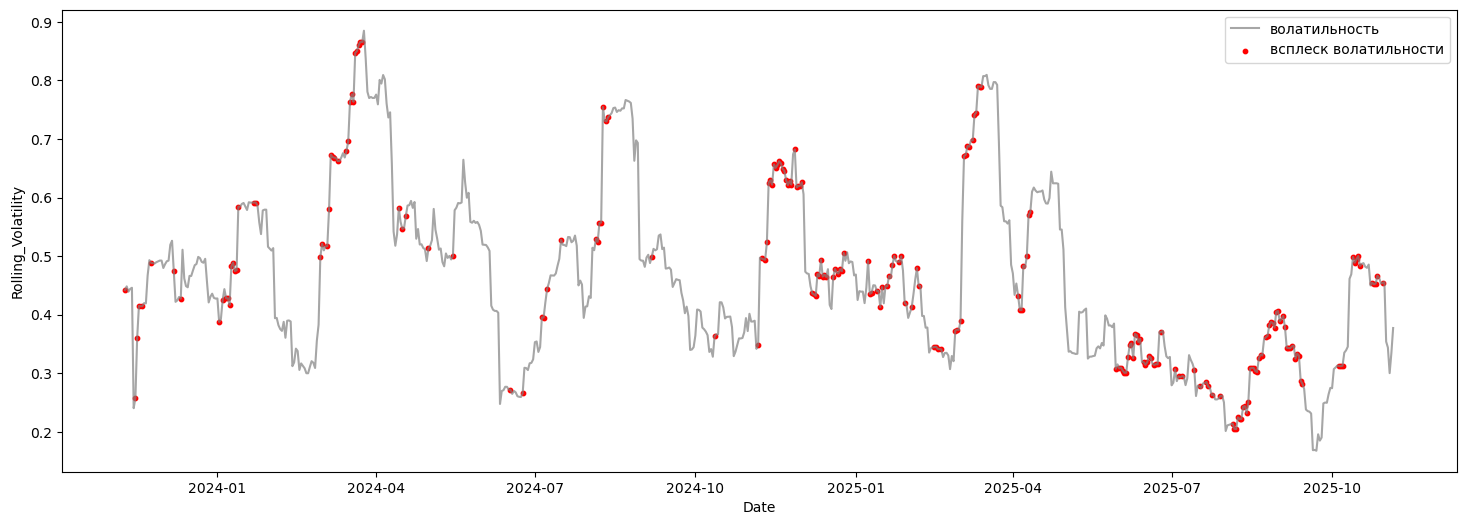

In [39]:
df_test = df.iloc[train_size+look_back:]
index_test = df.index[train_size+10:]

y_final_test = pd.Series(y_pred_final, index=index_test)

anom_test  = y_final_test[y_pred_final == 1].index


plt.figure(figsize=(18,6))
plt.plot(df_test.index, df_test['Rolling_Volatility'], color='gray', label='волатильность', alpha=0.7)
plt.scatter(anom_test, df_test.loc[anom_test, 'Rolling_Volatility'], color='red', label='всплеск волатильности', s=10)

plt.xlabel('Date')
plt.ylabel('Rolling_Volatility')
plt.legend()
plt.show()

Модель даёт довольно много сигналов перед настоящими всплесками волатильности, но очень много ложных сигналов в местах "пилы". В идеале придумать способ как убрать эти ложные предсказания

In [41]:
#  Сначала рассчитаем SMA (Скользящую среднюю) на ПОЛНОМ датафрейме
# SMA 50 - классический индикатор среднесрочного тренда
df['SMA_50'] = df['Close'].rolling(window=50).mean()

test_data = df.iloc[train_size:].copy()
test_data = test_data.iloc[:len(y_pred_final)]
test_data['Signal'] = y_pred_final

# Сдвигаем сигнал на 1 день (действуем завтра по сегодняшнему сигналу)
test_data['Signal_Shifted'] = test_data['Signal'].shift(1).fillna(0)

test_data['Strategy_BuyHold'] = test_data['Log_Return']

#  "Мягкий Хедж" 50% Cash
# Если сигнал 1: Доходность = 50% от доходности BTC (мы наполовину в USDT)
# Если сигнал 0: Доходность = 100% от доходности BTC
test_data['Strategy_SoftHedge'] = np.where(
    test_data['Signal_Shifted'] == 1, 
    test_data['Log_Return'] * 0.5,  # Снижаем риск (и прибыль) в 2 раза
    test_data['Log_Return']
)

In [42]:
# НОВАЯ СТРАТЕГИЯ 2: Умный Фильтр
# Условие выхода: Сигнал модели == 1 И Цена < SMA_50 (Тренд нисходящий)
# shift(1) у цен тоже нужен, так как мы принимаем решение на открытии дня
close_shifted = test_data['Close'].shift(1)
sma_shifted = test_data['SMA_50'].shift(1)

# Определяем условие паники
panic_condition = (test_data['Signal_Shifted'] == 1) & (close_shifted < sma_shifted)

test_data['Strategy_TrendFilter'] = np.where(
    panic_condition, 
    0,                      # Выходим в кэш полностью, так как все плохо (тренд вниз + волатильность)
    test_data['Log_Return'] # Иначе держим, даже если есть сигнал волатильности (игнорируем ложные тревоги на росте)
)

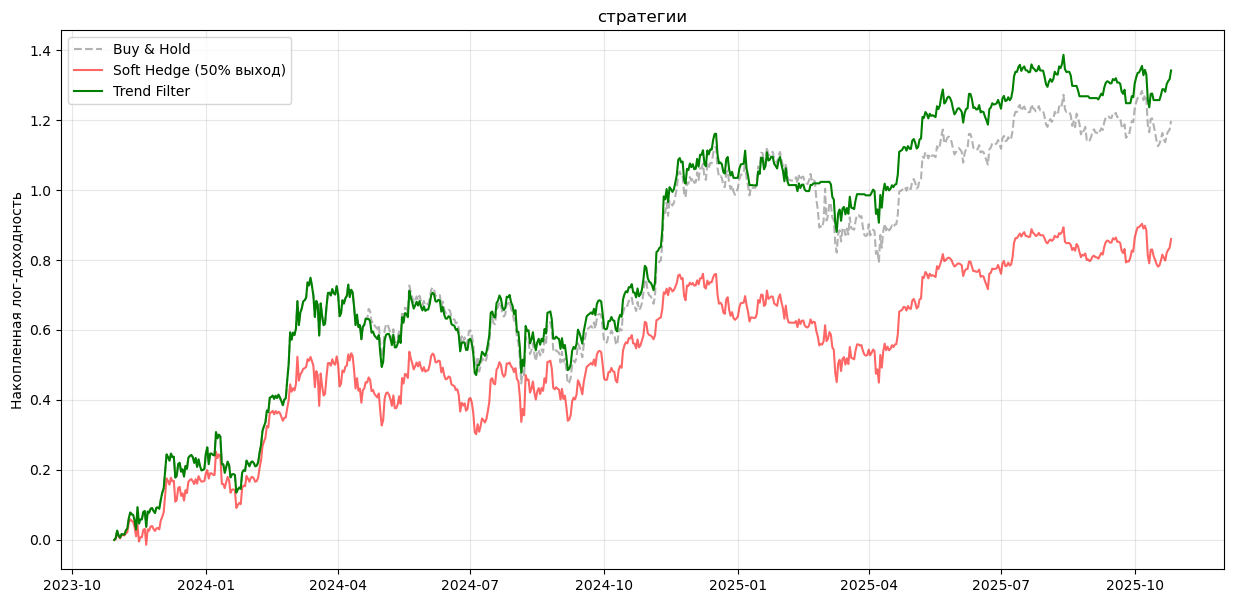

In [43]:
plt.figure(figsize=(15, 7))

cum_buy_hold = test_data['Strategy_BuyHold'].cumsum()
cum_soft_hedge = test_data['Strategy_SoftHedge'].cumsum()
cum_trend_filter = test_data['Strategy_TrendFilter'].cumsum()

plt.plot(cum_buy_hold, label='Buy & Hold', color='gray', alpha=0.6, linestyle='--')
plt.plot(cum_soft_hedge, label='Soft Hedge (50% выход)', color='red', alpha=0.6)
plt.plot(cum_trend_filter, label='Trend Filter', color='green', linewidth=1.5)

plt.title('стратегии')
plt.ylabel('Накопленная лог-доходность')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [44]:
# РАСЧЕТ МЕТРИК
def calculate_metrics(series, name):
    total_return = np.exp(series.sum()) - 1 # Перевод из лог-доходности в проценты
    volatility = series.std() * np.sqrt(365) # Годовая волатильность
    sharpe = (series.mean() / series.std()) * np.sqrt(365) # Шарп (без risk-free rate)
    
    # Расчет максимальной просадки (Max Drawdown)
    cum_returns = series.cumsum()
    peak = cum_returns.cummax()
    drawdown = cum_returns - peak
    max_drawdown = np.exp(drawdown.min()) - 1
    
    return {
        'Стратегия': name,
        'Доходность (Total)': f"{total_return*100:.1f}%",
        'Шарп (Sharpe)': f"{sharpe:.2f}",
        'Макс. просадка': f"{max_drawdown*100:.1f}%"
    }
metrics = []
metrics.append(calculate_metrics(test_data['Strategy_BuyHold'], 'Buy & Hold'))
metrics.append(calculate_metrics(test_data['Strategy_SoftHedge'], 'Soft Hedge (50/50)'))
metrics.append(calculate_metrics(test_data['Strategy_TrendFilter'], 'Trend Filter (Smart)'))

print("\n=== РЕЗУЛЬТАТЫ УЛУЧШЕННЫХ СТРАТЕГИЙ ===")
print(pd.DataFrame(metrics))


=== РЕЗУЛЬТАТЫ УЛУЧШЕННЫХ СТРАТЕГИЙ ===
              Стратегия Доходность (Total) Шарп (Sharpe) Макс. просадка
0            Buy & Hold             231.4%          1.25         -28.1%
1    Soft Hedge (50/50)             136.3%          1.02         -26.8%
2  Trend Filter (Smart)             282.9%          1.47         -24.5%
